## CNN 1b

### Load Packages

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

### Datensatz laden und DatenLoader

In [8]:
# Definiere die Dataset-Klasse
class HumorDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        input_ids = torch.tensor(np.array(self.data[index]["input_ids"]), dtype=torch.float32)  # (seq_len, embedding_dim)
        label = torch.tensor([self.data[index]["labels"]], dtype=torch.float32)  # (1,)
        return input_ids, label

    def __len__(self):
        return len(self.data)

# Lade die vorbereiteten Daten
train_data = torch.load(data_path + '/train.pt', weights_only=False)
val_data = torch.load(data_path + '/val.pt', weights_only=False)
test_data = torch.load(data_path + '/test.pt', weights_only=False)

train_dataset = HumorDataset(train_data)
val_dataset = HumorDataset(val_data)
test_dataset = HumorDataset(test_data)

# DataLoader erstellen
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Ableitung der Dimensionen aus den Daten
sample_input, _ = train_dataset[0]  # Extrahiere input_ids
seq_len, embedding_dim = sample_input.shape



### CNN-Modell definieren


In [9]:
# Single-Kernel CNN-Modell
class SingleKernelCNN(nn.Module):
    def __init__(self, embedding_dim, num_classes=1, kernel_size=5, num_filters=100, dropout=0.5, use_highway=True):
        super(SingleKernelCNN, self).__init__()
        # Convolutional Layer mit Kernel 
        self.conv = nn.Conv2d(1, num_filters, (kernel_size, embedding_dim))
        
        # Optional Highway Layer
        self.use_highway = use_highway
        if self.use_highway:
            self.highway = nn.Linear(num_filters, num_filters)
        
        # Fully Connected Layer
        self.fc = nn.Linear(num_filters, num_classes)
        
        # Dropout zur Regularisierung
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Eingabe x-Form: (batch_size, seq_len, embedding_dim)
        x = x.unsqueeze(1)  # Füge Kanaldimension hinzu: (batch_size, 1, seq_len, embedding_dim)
        
        # Convolution + ReLU
        x = F.relu(self.conv(x).squeeze(3))  # Entferne die letzte Dimension nach der Convolution
        
        # Max Pooling über die Sequenzlänge
        x = F.max_pool1d(x, x.size(2)).squeeze(2)  # Reduziere auf (batch_size, num_filters)
        
        # Optionaler Highway-Mechanismus
        if self.use_highway:
            highway_gate = torch.sigmoid(self.highway(x))
            x = highway_gate * F.relu(self.highway(x)) + (1 - highway_gate) * x
        
        # Dropout zur Regularisierung
        x = self.dropout(x)
        
        # Fully Connected Layer für die Ausgabe
        logits = self.fc(x)
        return torch.sigmoid(logits)  # Binäre Klassifikation




### Training des Modells


In [10]:
# Geräteauswahl: MPS (für macOS), CUDA (GPU), oder CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple MPS für macOS
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA CUDA
else:
    device = torch.device("cpu")  # Fallback auf CPU

# Initialisiere das Modell
model = SingleKernelCNN(embedding_dim=embedding_dim, num_classes=1, kernel_size=5, num_filters=100, dropout=0.5, use_highway=False).to(device)

# Verlustfunktion und Optimierer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  

# Lernraten-Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Trainingseinstellungen
epochs = 30  # Maximalanzahl an Epochen
best_val_loss = float('inf')
patience = 5  # Geduld für Early Stopping
counter = 0


# Liste zum Speichern der Trainingsverluste
train_losses = []

# Training und Validierung
for epoch in range(epochs):
    model.train()
    total_loss = 0
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            tepoch.update(1)
            tepoch.set_postfix(loss=loss.item())
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Speichere den Trainingsverlust
    
    # Validierung
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping ausgelöst!")
            break

/Users/michellegoppinger/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30: 100%|██████████| 124/124 [00:23<00:00,  5.22batch/s, loss=0.705]


Epoch 1, Train Loss: 0.6845, Val Loss: 0.6565


Epoch 2/30: 100%|██████████| 124/124 [00:23<00:00,  5.30batch/s, loss=0.728]


Epoch 2, Train Loss: 0.6486, Val Loss: 0.6301


Epoch 3/30: 100%|██████████| 124/124 [00:23<00:00,  5.24batch/s, loss=0.513]


Epoch 3, Train Loss: 0.6193, Val Loss: 0.6441


Epoch 4/30: 100%|██████████| 124/124 [00:23<00:00,  5.29batch/s, loss=0.53] 


Epoch 4, Train Loss: 0.5953, Val Loss: 0.6143


Epoch 5/30: 100%|██████████| 124/124 [00:24<00:00,  5.11batch/s, loss=0.391]


Epoch 5, Train Loss: 0.5613, Val Loss: 0.6189


Epoch 6/30: 100%|██████████| 124/124 [00:23<00:00,  5.25batch/s, loss=0.435]


Epoch 6, Train Loss: 0.5350, Val Loss: 0.6127


Epoch 7/30: 100%|██████████| 124/124 [00:23<00:00,  5.29batch/s, loss=0.595]


Epoch 7, Train Loss: 0.5055, Val Loss: 0.6162


Epoch 8/30: 100%|██████████| 124/124 [00:23<00:00,  5.27batch/s, loss=0.313]


Epoch 8, Train Loss: 0.4654, Val Loss: 0.6668


Epoch 9/30: 100%|██████████| 124/124 [00:23<00:00,  5.26batch/s, loss=0.438]


Epoch 9, Train Loss: 0.4299, Val Loss: 0.6240


Epoch 10/30: 100%|██████████| 124/124 [00:23<00:00,  5.23batch/s, loss=0.561]


Epoch 10, Train Loss: 0.3863, Val Loss: 0.6328


Epoch 11/30: 100%|██████████| 124/124 [00:23<00:00,  5.28batch/s, loss=0.321]


Epoch 11, Train Loss: 0.3553, Val Loss: 0.6676
Early Stopping ausgelöst!


### Trainingsverlust

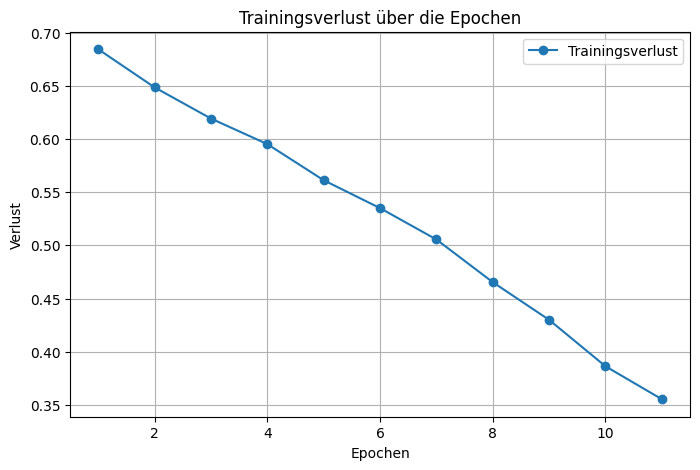

In [11]:
# Plot: Trainingsverlust über die Epochen
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Trainingsverlust", marker='o')
plt.xlabel("Epochen")
plt.ylabel("Verlust")
plt.title("Trainingsverlust über die Epochen")
plt.grid(True)
plt.legend()
plt.show()


### Finale Evaluierung & Confusion Matrix



In [12]:
# Testen des Modells
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        predictions = (outputs > 0.5).float()
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = [int(p[0]) for p in all_preds]
all_labels = [int(l[0]) for l in all_labels]

# Test-Accuracy und F1-Score berechnen
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f'🚀 Finale Test Accuracy: {accuracy:.4f}')
print(f'🚀 Finale Test F1 Score: {f1:.4f}')

/var/folders/l7/061cw0t95vz1myntpf9bj9540000gn/T/ipykernel_5620/1822405546.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.p

🚀 Finale Test Accuracy: 0.6518
🚀 Finale Test F1 Score: 0.6993


### Konfusionsmatrix

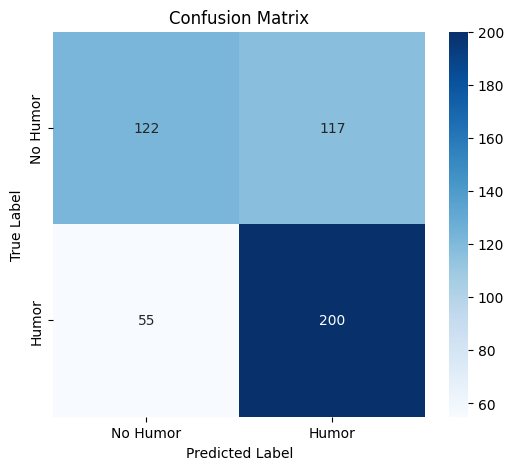

In [13]:
# Konfusionsmatrix visualisieren
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['No Humor', 'Humor'], yticklabels=['No Humor', 'Humor'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
